In [1]:
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付


import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

# Data Loading

In [2]:
df_train = pd.read_csv("../input/train.csv", index_col=0)
df_labels = pd.read_csv("../input/labels.csv", index_col=0)
print(f"df_train.shape:{df_train.shape}, df_labels.shape:{df_labels.shape}")

df_train.shape:(109237, 1), df_labels.shape:(1103, 1)


In [3]:
nb_class = df_labels.shape[0]
print(f"nb_class: {nb_class}")

nb_class: 1103


In [4]:
df_train.head()

,attribute_ids
id,
1000483014d91860,147 616 813
1000fe2e667721fe,51 616 734 813
1001614cb89646ee,776
10041eb49b297c08,51 671 698 813 1092
100501c227f8beea,13 404 492 903 1093


In [5]:
df_label_len = df_train.attribute_ids.str.split(" ").apply(len)

Text(0.5, 1.0, '# of label for each instance.')

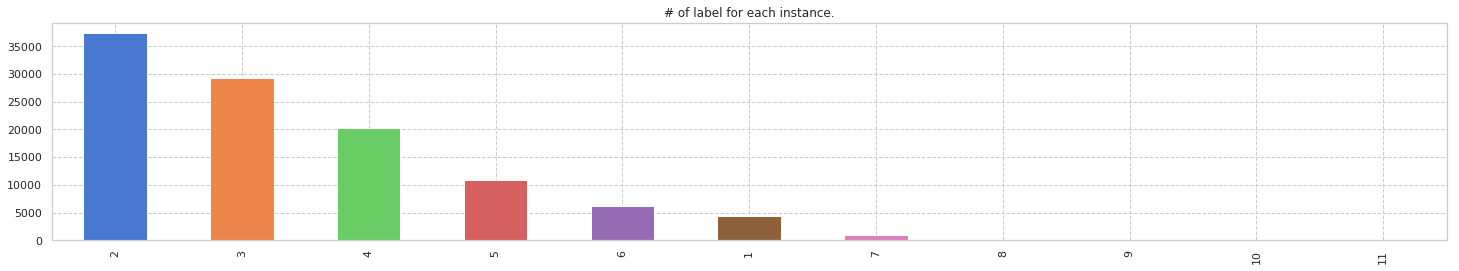

In [6]:
plt.figure(figsize=(25, 4))
df_label_len.value_counts().plot.bar()
plt.title(f"# of label for each instance.")

# Target

In [7]:
labels_all = df_train.attribute_ids.values.flatten()
df_cnt_label_set = pd.Series(labels_all).value_counts()
df_cnt_label_set.shape

(50238,)

In [8]:
# There are frequent combinations.
df_cnt_label_set.head(30)

13 405 896 1092     1158
813 896              586
194 1034             489
13 552               482
121 1059             465
121 433              425
13 626               365
79 1059              352
13 813 896           339
121 1039             332
189 1034             329
896 1092             328
121 962              290
79 1062              261
147 671 780 1034     245
1034 369             241
1059                 234
188 1034             230
684                  221
194 1059             221
121 724 955          219
79 487               218
147 813 896          210
304 487              201
813                  201
1092                 200
147 813              195
121 432 724          191
13 519               188
615 813 896          187
dtype: int64

In [9]:
cnt_each_label = np.hstack(df_train.attribute_ids.str.split(" ").values)

In [11]:
# top 30 frequent labels
target_each_cnt = pd.Series(cnt_each_label).value_counts()
target_each_cnt.head(30)

813     19970
1092    14281
147     13522
189     10375
13       9151
671      8419
51       7615
194      7394
1059     6564
121      6542
896      5955
1046     5591
79       5382
780      5259
156      5163
369      4416
744      3890
477      3692
738      3665
1034     3570
188      3500
835      3005
903      2552
420      2548
1099     2327
552      2180
485      2097
776      2075
161      2050
489      2045
dtype: int64

In [14]:
target_each_cnt.tail()

199    1
281    1
396    1
366    1
11     1
dtype: int64

In [12]:
target_each_cnt.shape

(1103,)

In [ ]:
cnt_each_label.astype(int).min(), cnt_each_label.astype(int).max()

# Co-occurence of labels

In [ ]:
def func(row):
    base = np.zeros(nb_class)
    for r in row:
        base[int(r)] = 1
    return base.astype(int)
attr_oo = df_train.attribute_ids.str.split(" ").apply(func)
attr_oo = np.vstack(np.array(attr_oo))
attr_oo.shape

In [ ]:
import scipy.sparse as sp
attr_oo_sp = sp.coo_matrix(attr_oo)

In [ ]:
co_occur = attr_oo_sp.T.dot(attr_oo_sp)
co_occur = co_occur.toarray()
co_occur.shape

In [ ]:
co_occur

In [ ]:
plt.figure(figsize=(24,20))
sns.heatmap(co_occur, vmin=0, vmax=100)

## labels

In [ ]:
df_labels.head()

In [ ]:
culture = df_labels.attribute_name[df_labels.attribute_name.str.contains("culture::")]
tag = df_labels.attribute_name[df_labels.attribute_name.str.contains("tag::")]

* attribute_id 0 - 397 -> culture
* attribute_id 398 - 1102 -> tag

In [ ]:
culture

In [ ]:
tag

In [ ]:
df_labels_split = df_labels.attribute_name.str.split("::", expand=True)

In [ ]:
df_labels_split.head()

In [ ]:
# There are 2 types of category
df_labels_split[0].value_counts()

In [ ]:
# all names are unique
df_labels_split[1].value_counts().sort_values(ascending=False).iloc[:10]

In [ ]:
df_labels_split[1][:30]